# Data Loading & Walking Graph Construction

In [1]:
import osmnx as ox, networkx as nx, pandas as pd, geopandas as gpd, numpy as np, folium

# SETTINGS
ox.settings.log_console = True
ox.settings.use_cache = True
PLACE_NAME = "Australian Capital Territory, Australia"
WALK_SPEED = 1.3  # m/s

# Load school dataset (government CSV)
schools = pd.read_csv("/home/kasfi/school-safety-demo/data/Census_Data_for_all_ACT_Schools_20250830.csv")
schools.head()

# Build walking graph from OSM
G = ox.graph_from_place(PLACE_NAME, network_type="walk", simplify=True)
G = ox.distance.add_edge_lengths(G)
print("Graph nodes:", len(G.nodes), "edges:", len(G.edges))


Graph nodes: 99790 edges: 294316


# Visualise datasets

,dataset,rows,cols,has_latlon,has_wkt
0,Crashes,70384,15,True,True
1,SchoolBus,511,10,True,True
2,BusRoutes,204,12,False,True
3,SchoolsCensus,27317,5,False,False
4,DailyJourneys,1918,7,False,False
5,ParkAndRide,20,4,False,True
6,SmartParking,46,14,True,True


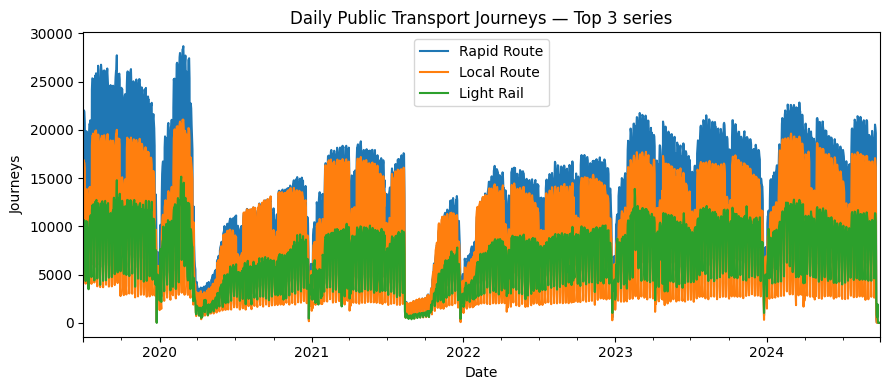

✔ Map saved to data/crucial_datasets_map.html


In [ ]:
# Trust Track Crucial-Only Visuals 
import os, warnings, math
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point, LineString
import folium
from folium.plugins import HeatMap, MarkerCluster
warnings.filterwarnings("ignore")

DATA_DIR = "data"

# Paths to Dataset 
ABS_ROAD_CRASH = "/home/kasfi/school-safety-demo/data/ACT_Road_Crash_Data_20250831.csv"
ABS_SCHOOLBUS  = "/home/kasfi/school-safety-demo/data/ACT_School_Bus_Services.csv"
ABS_BUSROUTES  = "/home/kasfi/school-safety-demo/data/Bus_Routes.csv"
ABS_SCHOOLS    = "/home/kasfi/school-safety-demo/data/Census_Data_for_all_ACT_Schools_20250830.csv"
ABS_DAILY      = "/home/kasfi/school-safety-demo/data/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250830.csv"
ABS_PNR        = "/home/kasfi/school-safety-demo/data/Park_And_Ride_Locations.csv"
ABS_SMARTPARK  = "/home/kasfi/school-safety-demo/data/Smart_Parking_Lots_20250831.csv"

def resolve_path(p: str) -> str:
    
    return p if os.path.isabs(p) else os.path.join(DATA_DIR, p)

# Final file variables 
F_ROAD_CRASH = resolve_path(ABS_ROAD_CRASH)
F_SCHOOLBUS  = resolve_path(ABS_SCHOOLBUS)
F_BUSROUTES  = resolve_path(ABS_BUSROUTES)
F_SCHOOLS    = resolve_path(ABS_SCHOOLS)
F_DAILY      = resolve_path(ABS_DAILY)
F_PNR        = resolve_path(ABS_PNR)
F_SMARTPARK  = resolve_path(ABS_SMARTPARK)

# helpers 
def safe_read_csv(p: str) -> pd.DataFrame:
    if not os.path.exists(p):
        print(f" Missing: {p}")
        return pd.DataFrame()
    try:
        return pd.read_csv(p)
    except Exception as e:
        print(f" Could not read {p}: {e}")
        return pd.DataFrame()

def parse_point_wkt(s):
    try:
        g = wkt.loads(str(s))
        if isinstance(g, Point):
            return g.y, g.x
    except Exception:
        pass
    return np.nan, np.nan

def parse_paren_latlon(txt):
    try:
        t = str(txt).strip().replace("(", "").replace(")", "")
        a,b = [z.strip() for z in t.split(",", 1)]
        return float(a), float(b)
    except Exception:
        return np.nan, np.nan

def first_col(df, names):
    for c in names:
        if c in df.columns: return c
        for col in df.columns:
            if col.lower() == c.lower(): return col
    return None

def extract_latlon(df: pd.DataFrame):
    out = df.copy()
    wkt_col = first_col(out, ("the_geom","geometry","wkt","Location"))
    if wkt_col is not None:
        sample = str(out[wkt_col].dropna().astype(str).head(1).values[0]) if not out[wkt_col].dropna().empty else ""
        if sample.upper().startswith("POINT"):
            out[["lat","lon"]] = out[wkt_col].apply(lambda s: pd.Series(parse_point_wkt(s)))
            return out
        if sample.strip().startswith("(") and "," in sample:
            out[["lat","lon"]] = out[wkt_col].apply(lambda s: pd.Series(parse_paren_latlon(s)))
            return out
    lat_c = first_col(out, ("lat","Latitude","LAT","Y"))
    lon_c = first_col(out, ("lon","Longitude","LONGITUDE","LON","X"))
    if lat_c and lon_c:
        out["lat"] = pd.to_numeric(out[lat_c], errors="coerce")
        out["lon"] = pd.to_numeric(out[lon_c], errors="coerce")
    return out

def detect_lines_wkt(df: pd.DataFrame):
    wkt_col = first_col(df, ("the_geom","geometry","wkt","GEOMETRY","GEOM"))
    lines = []
    if wkt_col is None: return lines
    for s in df[wkt_col].dropna().astype(str).values:
        try:
            g = wkt.loads(s)
            if isinstance(g, LineString):
                lines.append(g)
        except: 
            continue
    return lines

def small_schema_table(dfs: dict):
    rows = []
    for name, df in dfs.items():
        rows.append({
            "dataset": name,
            "rows": len(df),
            "cols": df.shape[1] if not df.empty else 0,
            "has_latlon": {"lat","lon"}.issubset(extract_latlon(df).columns),
            "has_wkt": first_col(df, ("the_geom","geometry","wkt","Location")) is not None
        })
    return pd.DataFrame(rows)

# load all tables
df_crash   = safe_read_csv(F_ROAD_CRASH)
df_schoolb = safe_read_csv(F_SCHOOLBUS)
df_bus     = safe_read_csv(F_BUSROUTES)
df_schools = safe_read_csv(F_SCHOOLS)
df_daily   = safe_read_csv(F_DAILY)
df_pnr     = safe_read_csv(F_PNR)
df_smart   = safe_read_csv(F_SMARTPARK)

# tiny schema/health table
health = small_schema_table({
    "Crashes": df_crash,
    "SchoolBus": df_schoolb,
    "BusRoutes": df_bus,
    "SchoolsCensus": df_schools,
    "DailyJourneys": df_daily,
    "ParkAndRide": df_pnr,
    "SmartParking": df_smart
})
display(health)

# Daily journeys: top-3 series over time 
if not df_daily.empty:
    date_col = first_col(df_daily, ("Date","date"))
    dts = df_daily.copy()
    if date_col:
        dts[date_col] = pd.to_datetime(dts[date_col], dayfirst=True, errors="coerce")
        meas_cols = [c for c in dts.columns if c != date_col]
        for c in meas_cols:
            dts[c] = pd.to_numeric(dts[c].astype(str).str.replace(",","").str.strip().replace({"": "0"}), errors="coerce")
        dts = dts.dropna(subset=[date_col]).sort_values(date_col)
        if not dts.empty and meas_cols:
            means = dts[meas_cols].mean().sort_values(ascending=False)
            top3 = means.head(3).index.tolist()
            plt.figure(figsize=(9,4))
            dts.set_index(date_col)[top3].plot(ax=plt.gca())
            plt.title("Daily Public Transport Journeys — Top 3 series")
            plt.xlabel("Date"); plt.ylabel("Journeys")
            plt.tight_layout(); plt.show()

# Crashes: yearly counts 
if not df_crash.empty:
    # try year column or parse a date
    year_col = first_col(df_crash, ("Year","year"))
    if year_col is None:
        dt_col = first_col(df_crash, ("Date","CrashDate","date"))
        if dt_col:
            yrs = pd.to_datetime(df_crash[dt_col], errors="coerce").dt.year
        else:
            yrs = pd.Series(dtype=int)
    else:
        yrs = pd.to_numeric(df_crash[year_col], errors="coerce")
    if not yrs.empty:
        plt.figure(figsize=(8,3.6))
        yrs.dropna().astype(int).value_counts().sort_index().plot(kind="bar")
        plt.title("Crashes per year"); plt.xlabel("Year"); plt.ylabel("Count")
        plt.tight_layout(); plt.show()
    # severity split (if present)
    sev_col = first_col(df_crash, ("Severity","severity","SEVERITY"))
    if sev_col:
        plt.figure(figsize=(6,3.2))
        df_crash[sev_col].astype(str).value_counts().head(5).plot(kind="barh")
        plt.title("Crash severity (top)"); plt.tight_layout(); plt.show()

# Parking snapshot: capacity vs availability 
def to_num(s):
    return pd.to_numeric(pd.Series(s).astype(str).str.replace(",",""), errors="coerce")

cap_cols  = [first_col(df_pnr, ("Capacity","TotalSpaces")), first_col(df_smart, ("Capacity","TotalSpaces"))]
avail_cols= [first_col(df_pnr, ("Available","FreeSpaces")), first_col(df_smart, ("Available","FreeSpaces"))]
pnr_cap   = to_num(df_pnr[cap_cols[0]]) if cap_cols[0] else pd.Series(dtype=float)
pnr_avail = to_num(df_pnr[avail_cols[0]]) if avail_cols[0] else pd.Series(dtype=float)
sp_cap    = to_num(df_smart[cap_cols[1]]) if cap_cols[1] else pd.Series(dtype=float)
sp_avail  = to_num(df_smart[avail_cols[1]]) if avail_cols[1] else pd.Series(dtype=float)

total_cap   = float(pnr_cap.fillna(0).sum() + sp_cap.fillna(0).sum())
total_avail = float(pnr_avail.fillna(0).sum() + sp_avail.fillna(0).sum())
if total_cap > 0:
    used = max(0.0, total_cap - total_avail)
    plt.figure(figsize=(5,3.2))
    plt.bar(["Available","Used"], [total_avail, used])
    plt.title("Parking capacity snapshot (PNR + Smart)")
    plt.tight_layout(); plt.show()

# Compact map with essential layers
CENTER = (-35.281, 149.128)
m = folium.Map(location=CENTER, zoom_start=12, control_scale=True)

# Crash heatmap (sample up to 5k)
cr = extract_latlon(df_crash)
if {"lat","lon"}.issubset(cr.columns):
    pts = cr.dropna(subset=["lat","lon"])
    sample = pts.sample(min(len(pts), 5000), random_state=42)
    HeatMap(sample[["lat","lon"]].values.tolist(), radius=10, blur=12, name="Crash heatmap").add_to(m)

# Bus routes 
bus_lines = detect_lines_wkt(df_bus)
if bus_lines:
    grp_bus = folium.FeatureGroup(name=f"Bus Routes ({len(bus_lines)})", show=True)
    for g in bus_lines[:200]:
        coords = [(lat, lon) for lon, lat in list(g.coords)]
        folium.PolyLine(coords, color="#ff7f0e", weight=2, opacity=0.7).add_to(grp_bus)
    grp_bus.add_to(m)

# School-bus stops 
sb = extract_latlon(df_schoolb)
if {"lat","lon"}.issubset(sb.columns):
    cluster_sb = MarkerCluster(name="School-bus stops").add_to(m)
    for _, r in sb.dropna(subset=["lat","lon"]).iterrows():
        folium.CircleMarker([float(r.lat), float(r.lon)], radius=4, color="#1f77b4",
                            fill=True, fill_opacity=0.8).add_to(cluster_sb)

# Parking 
parks_pts = []
for d in [df_pnr, df_smart]:
    pr = extract_latlon(d)
    if {"lat","lon"}.issubset(pr.columns):
        label_col = first_col(pr, ("Location","Name"))
        for _, r in pr.dropna(subset=["lat","lon"]).iterrows():
            label = str(r.get(label_col, "Parking"))
            parks_pts.append((float(r.lat), float(r.lon), label))
if parks_pts:
    cluster_p = MarkerCluster(name=f"Parking ({len(parks_pts)})").add_to(m)
    for lat, lon, label in parks_pts:
        folium.Marker([lat, lon], tooltip=label,
                      icon=folium.Icon(color="purple", icon="parking", prefix="fa")).add_to(cluster_p)

folium.LayerControl(collapsed=False).add_to(m)
out_map = os.path.join(DATA_DIR, "crucial_datasets_map.html")
m.save(out_map)
print(f" Map saved to {out_map}")



# Edge Safety Scoring & Graph Annotation

In [16]:
ROADCLASS_RISK = {
    "motorway": 1.00, "trunk": 0.95, "primary": 0.90, "secondary": 0.75,
    "tertiary": 0.60, "residential": 0.35, "service": 0.30,
    "living_street": 0.20, "footway": 0.10, "path": 0.10, "cycleway": 0.05
}

def edge_safety(data):
    hw = data.get("highway", "")
    if isinstance(hw, list): hw = hw[0]
    rc = ROADCLASS_RISK.get(hw, 0.5)
    sidewalk = str(data.get("sidewalk","")).lower()
    has_sidewalk = any(x in sidewalk for x in ["yes","both","left","right"])
    cycle = "cycleway" in str(data.get("cycleway","")).lower()
    safety = 100 - 25*rc - 20*rc - (15 if not has_sidewalk else 0) + (10 if cycle else 0)
    return max(0, min(100, safety))

for u,v,k,data in G.edges(keys=True, data=True):
    data["safety"] = edge_safety(data)
    data["risk"]   = 1 - data["safety"]/100
    data["time"]   = data["length"]/WALK_SPEED/60
    data["w_fast"] = data["time"]
    data["w_safe"] = data["risk"]*data["time"]


# Helper Functions & Config Setup

In [ ]:
# Trust Track · helpers 

import os, math, pandas as pd, numpy as np, osmnx as ox, networkx as nx
from datetime import date

# config 
BUS_SPEED_KMH   = 25.0     # average in-vehicle bus speed (fallback without GTFS)
BUS_BUFFER_MIN  = 3.0      # dwell/buffer minutes
BUS_BASE_SAFETY = 92.0     # bus is generally safer than roadside walking
K_NEAR_STOPS    = 10       # how many candidate bus start points to consider

# Setups
origin = globals().get("origin", (-35.281, 149.128))     # (lat, lon)
school_query = globals().get("school_query", "Ainslie School")
target_date = globals().get("target_date", date.today()) # python datetime.date
depart_time_str = globals().get("depart_time_str", "08:10:00")

# generic utils
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = (math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2)
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def parse_wkt_point_lonlat_to_latlon(txt):
    # 'POINT (149.12 -35.30)' -> (-35.30, 149.12)
    txt = str(txt).strip()
    if not txt.upper().startswith("POINT"):
        return None, None
    inside = txt[txt.find("(")+1: txt.find(")")]
    lon_str, lat_str = [t.strip() for t in inside.split()]
    lon, lat = float(lon_str), float(lat_str)
    return lat, lon

def parse_paren_latlon(txt):
    # '( -35.30, 149.12 )' -> (-35.30, 149.12)
    txt = str(txt).strip().replace("(", "").replace(")", "")
    if "," not in txt:
        return None, None
    lat_str, lon_str = [t.strip() for t in txt.split(",", 1)]
    return float(lat_str), float(lon_str)

def walk_leg(G, a_latlon, b_latlon, objective="fast"):
    node_a = ox.nearest_nodes(G, X=a_latlon[1], Y=a_latlon[0])
    node_b = ox.nearest_nodes(G, X=b_latlon[1], Y=b_latlon[0])
    weight = "w_fast" if objective=="fast" else "w_safe"
    r = nx.shortest_path(G, node_a, node_b, weight=weight)
    lengths, safeties, times = [], [], []
    for u,v in zip(r[:-1], r[1:]):
        variants = G.get_edge_data(u, v)
        _, data = min(variants.items(), key=lambda kv: kv[1].get("length", 1.0))
        lengths.append(float(data.get("length", 0.0)))
        safeties.append(float(data.get("safety", 50.0)))
        times.append(float(data.get("time_min", data.get("time", 0.0))))
    total_min = float(np.sum(times))
    mean_safety = float(np.average(safeties, weights=lengths)) if lengths else 0.0
    return total_min, mean_safety, r

def bus_minutes_estimate(a_lat, a_lon, b_lat, b_lon):
    km = haversine_km(a_lat, a_lon, b_lat, b_lon)
    return (km / BUS_SPEED_KMH) * 60.0 + BUS_BUFFER_MIN

def load_csv_with_fallback(fname):
    
    p_local = os.path.join("data", fname)
    p_upload = os.path.join("/mnt/data", fname)
    if os.path.exists(p_local):
        return pd.read_csv(p_local)
    elif os.path.exists(p_upload):
        return pd.read_csv(p_upload)
    else:
        raise FileNotFoundError(f"Could not find {fname} in ./data or /mnt/data.")

def crowding_factor_from_daily_csv(df_daily: pd.DataFrame, dt: date) -> float:
    
    df = df_daily.copy()
    # parse date column
    df["Date_parsed"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    # numeric totals
    measure_cols = [c for c in df.columns if c not in ["Date","Date_parsed"]]
    for c in measure_cols:
        df[c] = (df[c].astype(str).str.replace(",","").str.strip().replace({"": "0"})).astype(float)
    df["total"] = df[measure_cols].sum(axis=1)
    # pick the row for requested date (or closest previous if missing)
    target_ts = pd.Timestamp(dt)
    sel = df.loc[df["Date_parsed"] == target_ts]
    if sel.empty:
        sel = df.sort_values("Date_parsed").iloc[[-1]]  # fallback: latest
    today_total = float(sel["total"].iloc[0])
    norm = today_total / max(1.0, df["total"].quantile(0.95))  # scale by 95th percentile
    # clamp 0.3..1.0
    return float(np.clip(norm, 0.3, 1.0))


# Routing & Recommendation Engine

In [ ]:

import os, math, pandas as pd, numpy as np, folium
import osmnx as ox, networkx as nx
from shapely import wkt
from shapely.ops import transform
from shapely.geometry import Point
from pyproj import Transformer
from IPython.display import display
from typing import Tuple, Dict, Any
from datetime import date

# Speed/behavior toggles
FAST_MODE                  = True        # keep True for quick runs
ALLOW_OSM_PARKING_FALLBACK = True        # 
OSM_PARKING_DIST_M         = 2000 if FAST_MODE else 4000
BUS_POLYLINE_SAMPLES       = 80 if FAST_MODE else 140
SNAP_THRESHOLDS_M          = [600, 1000] if FAST_MODE else [500, 800, 1200, 2000]
K_NEAR_STOPS               = 6 if FAST_MODE else 10
PR_TOP_N                   = 2 if FAST_MODE else 3
PR_LIMIT_KM_TO_SCHOOL      = 3.0 if FAST_MODE else 4.0
CAR_GRAPH_PADDING_KM       = 3.0 if FAST_MODE else 8.0  # extra coverage around O->chosen parking

# OSMnx caching (helps a lot on repeat runs)
ox.settings.use_cache   = True
ox.settings.cache_folder = "./.osmnx_cache"
ox.settings.timeout     = 30

# Config 
BUS_POLYLINE_CSV    = "/home/kasfi/school-safety-demo/data/Bus_Routes.csv"                     
SCHOOL_BUS_CSV      = "/home/kasfi/school-safety-demo/data/ACT_School_Bus_Services.csv"        
DAILY_JOURNEYS_CSV  = "/home/kasfi/school-safety-demo/data/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250830.csv"
PARK_AND_RIDE_CSV   = "/home/kasfi/school-safety-demo/data/Park_And_Ride_Locations.csv"        

REGION_HINT = "Australia"

# Graph G (walking) must already have 'w_fast', 'w_safe', and edge attrs: length, safety, risk, time_min|time

# Bus model defaults
BUS_SPEED_KMH_DEFAULT   = 25.0
BUS_BUFFER_MIN_DEFAULT  = 3.0
BUS_BASE_SAFETY_DEFAULT = 92.0

# Viability filters
MAX_WALK_TO_BOARD_MIN     = 15.0
MIN_BUS_MINUTES_TO_COUNT  = 6.0

# Car model (drive graph built lazily)
PARKING_BUFFER_MIN      = 4.0
CAR_BASE_SAFETY         = 95.0

# Recommendation knobs
TIME_BETTER_BY_MIN = 3.0
RISK_BETTER_BY_MIN = 2.0

# Utilities

def validate_graph(G: nx.MultiDiGraph) -> str:
    try:
        edge_any = next(iter(G.edges(data=True)))[2]
    except StopIteration:
        raise RuntimeError("Graph G has no edges.")
    need = {"length","safety","risk"}
    missing = need - set(edge_any.keys())
    if missing:
        raise RuntimeError(f"Edge attributes missing: {missing}.")
    for w in ("w_fast","w_safe"):
        if w not in edge_any:
            raise RuntimeError(f"Missing edge weight '{w}'.")
    time_key = "time_min" if "time_min" in edge_any else ("time" if "time" in edge_any else None)
    if time_key is None:
        raise RuntimeError("No 'time_min' or 'time' on edges.")
    return time_key

def smart_query(place: str, region_hint: str = "Australia") -> str:
    s = place.strip()
    if ("," not in s) and not any(ch.isdigit() for ch in s):
        return f"{s}, {region_hint}"
    return s

def geocode_place(place: str, region_hint: str = "Australia") -> Tuple[float, float, str]:
    q = smart_query(place, region_hint)
    lat, lon = ox.geocoder.geocode(q)
    return float(lat), float(lon), q

def nearest_node(G: nx.MultiDiGraph, lat: float, lon: float) -> int:
    return ox.nearest_nodes(G, X=lon, Y=lat)

def iter_best_edges(G: nx.MultiDiGraph, route):
    for u, v in zip(route[:-1], route[1:]):
        variants = G.get_edge_data(u, v)
        key, data = min(variants.items(), key=lambda kv: float(kv[1].get("length", 1e12)))
        yield data

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = (math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2)
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def parse_wkt_point_lonlat_to_latlon(txt):
    txt = str(txt).strip()
    if not txt.upper().startswith("POINT"):
        return None, None
    inside = txt[txt.find("(")+1: txt.find(")")]
    lon_str, lat_str = [t.strip() for t in inside.split()]
    lon, lat = float(lon_str), float(lat_str)
    return lat, lon

def parse_paren_latlon(txt):
    txt = str(txt).strip().replace("(", "").replace(")", "")
    if "," not in txt:
        return None, None
    lat_str, lon_str = [t.strip() for t in txt.split(",", 1)]
    return float(lat_str), float(lon_str)

def load_csv_with_fallback(path_or_name):
    if os.path.exists(path_or_name):
        return pd.read_csv(path_or_name)
    p_local = os.path.join("data", os.path.basename(path_or_name))
    p_upload = os.path.join("/mnt/data", os.path.basename(path_or_name))
    if os.path.exists(p_local):  return pd.read_csv(p_local)
    if os.path.exists(p_upload): return pd.read_csv(p_upload)
    raise FileNotFoundError(f"Could not find {path_or_name} or in ./data or /mnt/data.")

# Walk engines & drawing

def plan_walk_routes(G: nx.MultiDiGraph, orig_lat: float, orig_lon: float, dest_lat: float, dest_lon: float) -> Dict[str, Any]:
    time_key = validate_graph(G)
    orig_node = nearest_node(G, orig_lat, orig_lon)
    dest_node = nearest_node(G, dest_lat, dest_lon)
    r_fast = nx.shortest_path(G, orig_node, dest_node, weight="w_fast")
    r_safe = nx.shortest_path(G, orig_node, dest_node, weight="w_safe")

    def route_stats(route):
        lengths, safeties, times = [], [], []
        for data in iter_best_edges(G, route):
            lengths.append(float(data.get("length", 0.0)))
            safeties.append(float(data.get("safety", 50.0)))
            times.append(float(data.get(time_key, 0.0)))
        total_time = float(np.sum(times)) if times else 0.0
        mean_safety = float(np.average(safeties, weights=lengths)) if lengths else 0.0
        return total_time, mean_safety

    t_fast, s_fast = route_stats(r_fast)
    t_safe, s_safe = route_stats(r_safe)
    same = (r_fast == r_safe)

    if same:
        m = ox.plot_route_folium(G, r_safe, color="green", weight=5, opacity=0.85)
    else:
        m = ox.plot_route_folium(G, r_fast, color="blue", weight=4, opacity=0.75)
        ox.plot_route_folium(G, r_safe, route_map=m, color="green", weight=4, opacity=0.75)

    folium.Marker([orig_lat, orig_lon], tooltip="Origin").add_to(m)
    folium.Marker([dest_lat, dest_lon], tooltip="Destination", icon=folium.Icon(color="red")).add_to(m)

    walk_risk_minutes_safe = (1 - s_safe / 100.0) * t_safe

    return {
        "routes": {"fast": r_fast, "safe": r_safe, "same": same},
        "stats": {
            "fast": {"time_min": round(t_fast, 1), "mean_safety": round(s_fast)},
            "safe": {"time_min": round(t_safe, 1), "mean_safety": round(s_safe)},
            "risk_minutes_safe": round(walk_risk_minutes_safe, 2),
        },
        "map": m,
    }

def draw_walk_leg(m: folium.Map, G: nx.MultiDiGraph,
                  a_latlon: Tuple[float,float], b_latlon: Tuple[float,float],
                  objective: str = "safe", color: str = "orange", weight: int = 4, opacity: float = 0.8):
    _ = validate_graph(G)
    node_a = nearest_node(G, a_latlon[0], a_latlon[1])
    node_b = nearest_node(G, b_latlon[0], b_latlon[1])
    weight_key = "w_fast" if objective == "fast" else "w_safe"
    r = nx.shortest_path(G, node_a, node_b, weight=weight_key)
    ox.plot_route_folium(G, r, route_map=m, color=color, weight=weight, opacity=opacity)
    return r

# Bus engines 

def walk_leg(G: nx.MultiDiGraph, a_latlon: Tuple[float, float], b_latlon: Tuple[float, float],
             objective: str, time_key: str) -> Tuple[float, float]:
    node_a = nearest_node(G, a_latlon[0], a_latlon[1])
    node_b = nearest_node(G, b_latlon[0], b_latlon[1])
    weight = "w_fast" if objective == "fast" else "w_safe"
    r = nx.shortest_path(G, node_a, node_b, weight=weight)
    lengths, safeties, times = [], [], []
    for data in iter_best_edges(G, r):
        lengths.append(float(data.get("length", 0.0)))
        safeties.append(float(data.get("safety", 50.0)))
        times.append(float(data.get(time_key, 0.0)))
    total_time_min = float(np.sum(times))
    mean_safety = float(np.average(safeties, weights=lengths)) if lengths else 0.0
    return total_time_min, mean_safety

def evaluate_bus_candidates(
    G, origin, dest, routes_df, snap_thresholds_m=SNAP_THRESHOLDS_M,
    bus_speed_kmh=BUS_SPEED_KMH_DEFAULT, bus_buffer_min=BUS_BUFFER_MIN_DEFAULT, bus_assumed_safety=BUS_BASE_SAFETY_DEFAULT
) -> pd.DataFrame:
    time_key = validate_graph(G)
    assert "the_geom" in routes_df.columns, "CSV must contain 'the_geom' WKT geometry column."
    to_m = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
    to_ll = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True).transform
    origin_lonlat = (origin[1], origin[0]); dest_lonlat = (dest[1], dest[0])
    origin_m = transform(to_m, Point(origin_lonlat)); dest_m = transform(to_m, Point(dest_lonlat))

    def evaluate_with_threshold(thresh_m: float) -> pd.DataFrame:
        rows = []
        for _, row in routes_df.iterrows():
            try: geom_wgs = wkt.loads(str(row["the_geom"]))
            except Exception: continue
            if geom_wgs is None: continue
            geom_m = transform(to_m, geom_wgs)
            if geom_m.is_empty: continue
            d_o = geom_m.distance(origin_m); d_d = geom_m.distance(dest_m)
            if d_o > thresh_m or d_d > thresh_m: continue
            s_o = geom_m.project(origin_m); s_d = geom_m.project(dest_m)
            bus_m = abs(s_d - s_o)
            bus_min = (bus_m / (bus_speed_kmh * 1000 / 3600.0)) / 60.0 + bus_buffer_min
            p_o_ll = transform(to_ll, geom_m.interpolate(s_o)); p_d_ll = transform(to_ll, geom_m.interpolate(s_d))
            o_latlon = (p_o_ll.y, p_o_ll.x); d_latlon = (p_d_ll.y, p_d_ll.x)
            w1_fast_min, w1_fast_score = walk_leg(G, origin, o_latlon, "fast", time_key)
            w2_fast_min, w2_fast_score = walk_leg(G, d_latlon, dest,   "fast", time_key)
            w1_safe_min, w1_safe_score = walk_leg(G, origin, o_latlon, "safe", time_key)
            w2_safe_min, w2_safe_score = walk_leg(G, d_latlon, dest,   "safe", time_key)
            total_fast_minutes = w1_fast_min + bus_min + w2_fast_min
            w1_risk_min  = (1 - w1_safe_score / 100.0) * w1_safe_min
            bus_risk_min = (1 - BUS_BASE_SAFETY_DEFAULT / 100.0) * bus_min
            w2_risk_min  = (1 - w2_safe_score / 100.0) * w2_safe_min
            total_risk_minutes = w1_risk_min + bus_risk_min + w2_risk_min
            rows.append({
                "route_short": row.get("short_name", ""), "route_long": row.get("long_name", ""),
                "polyline_label": row.get("route_id", "") or row.get("shape_id", "") or "bus_polyline",
                "the_geom": str(row["the_geom"]),
                "bus_min": bus_min,
                "o_lat": o_latlon[0], "o_lon": o_latlon[1],
                "d_lat": d_latlon[0], "d_lon": d_latlon[1],
                "w1_fast_min": w1_fast_min, "w2_fast_min": w2_fast_min,
                "w1_safe_min": w1_safe_min, "w2_safe_min": w2_safe_min,
                "w1_safe_score": w1_safe_score, "w2_safe_score": w2_safe_score,
                "total_minutes_fast": total_fast_minutes,
                "total_risk_minutes_safe": total_risk_minutes,
            })
        return pd.DataFrame(rows)

    for thr in snap_thresholds_m:
        df = evaluate_with_threshold(thr)
        if not df.empty:
            df.attrs["threshold_used_m"] = thr
            return df
    return pd.DataFrame()

def draw_bus_segment_polyline(m: folium.Map, winning_row: pd.Series,
                              origin_lat: float, origin_lon: float,
                              dest_lat: float, dest_lon: float,
                              color="orange", samples=BUS_POLYLINE_SAMPLES):
    to_m = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
    to_ll = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True).transform
    geom_wgs = wkt.loads(str(winning_row["the_geom"]))
    geom_m   = transform(to_m, geom_wgs)
    o_pt_m = transform(to_m, Point((origin_lon, origin_lat)))
    d_pt_m = transform(to_m, Point((dest_lon, dest_lat)))
    s_o = geom_m.project(o_pt_m); s_d = geom_m.project(d_pt_m)
    a, b = (s_o, s_d) if s_o <= s_d else (s_d, s_o)
    ts = np.linspace(a, b, samples)
    pts_ll = [transform(to_ll, geom_m.interpolate(t)) for t in ts]
    coords = [(p.y, p.x) for p in pts_ll]
    folium.PolyLine(coords, color=color, weight=5, opacity=0.85, tooltip="Bus segment").add_to(m)
    folium.CircleMarker([winning_row.o_lat, winning_row.o_lon], radius=6, color=color, tooltip="Bus board here").add_to(m)
    folium.CircleMarker([winning_row.d_lat, winning_row.d_lon], radius=6, color=color, tooltip="Bus alight here").add_to(m)

# School-Bus engine

def bus_minutes_estimate(a_lat, a_lon, b_lat, b_lon, bus_speed_kmh=BUS_SPEED_KMH_DEFAULT, buffer_min=BUS_BUFFER_MIN_DEFAULT):
    km = haversine_km(a_lat, a_lon, b_lat, b_lon)
    return (km / max(1e-6, bus_speed_kmh)) * 60.0 + buffer_min

def evaluate_school_bus_csv(G, origin_latlon, dest_latlon, school_bus_df, school_query,
                            k_near=K_NEAR_STOPS) -> pd.DataFrame:
    time_key = validate_graph(G)
    if "Location" not in school_bus_df.columns:
        return pd.DataFrame()
    df = school_bus_df.copy()
    df["lat"], df["lon"] = zip(*df["Location"].map(parse_wkt_point_lonlat_to_latlon))
    df = df.dropna(subset=["lat","lon"]).copy()
    if "School Name" in df.columns:
        filt = df["School Name"].astype(str).str.contains(str(school_query), case=False, na=False)
        df_school = df[filt].copy()
        if df_school.empty:
            df_school = df.copy()
    else:
        df_school = df.copy()
    o_lat, o_lon = origin_latlon; d_lat, d_lon = dest_latlon
    df_school["dist_o_km"] = df_school.apply(lambda r: haversine_km(o_lat, o_lon, r.lat, r.lon), axis=1)
    near_o = df_school.nsmallest(k_near, "dist_o_km").reset_index(drop=True)

    rows = []
    for _, row in near_o.iterrows():
        w_fast_min, w_fast_score = walk_leg(G, (o_lat, o_lon), (row.lat, row.lon), "fast", time_key)
        if w_fast_min > MAX_WALK_TO_BOARD_MIN:
            continue
        w_safe_min, w_safe_score = walk_leg(G, (o_lat, o_lon), (row.lat, row.lon), "safe", time_key)
        bus_min = bus_minutes_estimate(row.lat, row.lon, d_lat, d_lon)
        if bus_min < MIN_BUS_MINUTES_TO_COUNT:
            continue
        total_fast = w_fast_min + bus_min
        risk_minutes = (1 - w_safe_score/100.0) * w_safe_min + (1 - BUS_BASE_SAFETY_DEFAULT/100.0) * bus_min
        rows.append({
            "start_label": f"{row.get('Description','')} {row.get('RouteNumber','')}".strip(),
            "start_lat": row.lat, "start_lon": row.lon,
            "w_fast_min": w_fast_min, "w_safe_min": w_safe_min,
            "w_safe_score": w_safe_score,
            "bus_min": bus_min,
            "total_minutes_fast": total_fast,
            "risk_minutes_safe": risk_minutes,
        })
    return pd.DataFrame(rows)

# Parking sources (CSV first, optional OSM fallback)

def osm_parking_near(dest_lat: float, dest_lon: float, dist_m: int) -> pd.DataFrame:
    if not ALLOW_OSM_PARKING_FALLBACK:
        return pd.DataFrame(columns=["Point","Location"])
    try:
        tags = {"amenity": ["parking"]}  # keep small for speed
        gdf = ox.geometries_from_point((dest_lat, dest_lon), dist=dist_m, tags=tags)
        if gdf.empty:
            return pd.DataFrame(columns=["Point","Location"])
        gdf = gdf.to_crs(4326)
        geom_pts = gdf.geometry.centroid.where(gdf.geometry.type != "Point", gdf.geometry)
        df = pd.DataFrame({
            "Location": gdf.get("name").fillna("OSM parking"),
            "lat": geom_pts.y.values,
            "lon": geom_pts.x.values,
        }).dropna(subset=["lat","lon"])
        df["Point"] = df.apply(lambda r: f"( {r.lat:.6f}, {r.lon:.6f} )", axis=1)
        return df[["Point","Location"]]
    except Exception:
        return pd.DataFrame(columns=["Point","Location"])

def load_parking_candidates(dest_lat: float, dest_lon: float) -> pd.DataFrame:
    
    local = pd.DataFrame(columns=["Point","Location"])
    try:
        local = load_csv_with_fallback(PARK_AND_RIDE_CSV)[["Point","Location"]]
    except Exception:
        pass
    if not local.empty:
        return local.drop_duplicates()
    return osm_parking_near(dest_lat, dest_lon, OSM_PARKING_DIST_M)

# Park-&-Stride (walk-only) 

def evaluate_park_and_stride(G, dest_latlon: Tuple[float,float], pr_df_points: pd.DataFrame,
                             limit_km: float = PR_LIMIT_KM_TO_SCHOOL, top_n: int = PR_TOP_N) -> pd.DataFrame:
    if "Point" not in pr_df_points.columns:
        return pd.DataFrame()
    def _parse_point(s):
        lat, lon = parse_paren_latlon(s); return pd.Series({"lat": lat, "lon": lon})
    df = pr_df_points.copy()
    pts = df["Point"].apply(_parse_point)
    df = pd.concat([df, pts], axis=1).dropna(subset=["lat","lon"]).copy()
    d_lat, d_lon = dest_latlon
    df["km_to_school"] = df.apply(lambda r: haversine_km(d_lat, d_lon, r.lat, r.lon), axis=1)
    cand = df[df.km_to_school <= limit_km].copy()
    if cand.empty: cand = df.copy()
    rows = []
    for _, r in cand.iterrows():
        w_fast_min, w_safe_score = walk_leg(G, (r.lat, r.lon), (d_lat, d_lon), "fast", validate_graph(G))
        w_safe_min, _             = walk_leg(G, (r.lat, r.lon), (d_lat, d_lon), "safe", validate_graph(G))
        rows.append({
            "site": r.get("Location", "Parking"),
            "lat": r.lat, "lon": r.lon,
            "walk_fast_min": w_fast_min,
            "walk_safe_min": w_safe_min,
            "walk_mean_safety": w_safe_score,
            "km_to_school": r.km_to_school
        })
    pr_res = pd.DataFrame(rows)
    if pr_res.empty: return pr_res
    pr_res = pr_res.sort_values(["walk_safe_min","walk_mean_safety"], ascending=[True, False]).head(top_n)
    return pr_res.reset_index(drop=True)

# Lazy CAR (only if no bus viable)

def build_car_graph(center_lat: float, center_lon: float, radius_km: float) -> nx.MultiDiGraph:
    Gc = ox.graph_from_point((center_lat, center_lon), dist=int(radius_km*1000), network_type="drive")
    Gc = ox.add_edge_speeds(Gc)
    Gc = ox.add_edge_travel_times(Gc)
    return Gc

def car_drive_time_minutes(Gc: nx.MultiDiGraph, o_lat: float, o_lon: float, d_lat: float, d_lon: float) -> Tuple[float, list]:
    o = ox.nearest_nodes(Gc, X=o_lon, Y=o_lat); d = ox.nearest_nodes(Gc, X=d_lon, Y=d_lat)
    r = nx.shortest_path(Gc, o, d, weight="travel_time")
    tt = 0.0
    for u,v,k,data in Gc.edges(keys=True, data=True):
        pass
    # Sum travel_time along route (simple way)
    edge_attrs = ox.utils_graph.get_route_edge_attributes(Gc, r, "travel_time")
    tt = float(np.sum([ea if ea is not None else 0.0 for ea in edge_attrs]))
    return tt/60.0, r

def draw_car_route(m: folium.Map, Gc: nx.MultiDiGraph, route_nodes: list, color="gray", weight=6, opacity=0.7):
    gdf = ox.utils_graph.route_to_gdf(Gc, route_nodes)
    if not gdf.empty:
        coords = [(lat, lon) for lon, lat in gdf.iloc[0].geometry.coords]
        folium.PolyLine(coords, color=color, weight=weight, opacity=opacity, tooltip="Drive").add_to(m)

# Unified recommender & UI 

def recommend_itinerary_with_school_bus_and_pr(
    G: nx.MultiDiGraph,
    origin_name: str,
    dest_name: str,
    bus_polyline_csv_path: str,
    school_bus_csv_path: str,
    school_query: str,
    target_date: date = date.today(),
):
    time_key = validate_graph(G)

    # Geocode origin/destination (school)
    o_lat, o_lon, o_label = geocode_place(origin_name, REGION_HINT)
    d_lat, d_lon, d_label = geocode_place(dest_name,  REGION_HINT)

    # Walk-only baseline
    walk = plan_walk_routes(G, o_lat, o_lon, d_lat, d_lon)
    walk_fast_time = float(walk["stats"]["fast"]["time_min"])
    walk_safe_risk = float(walk["stats"]["risk_minutes_safe"])

    # Load CSVs
    routes_df     = load_csv_with_fallback(bus_polyline_csv_path)
    school_bus_df = load_csv_with_fallback(school_bus_csv_path)

    # Bus via polyline candidates
    bus_df = evaluate_bus_candidates(
        G, (o_lat, o_lon), (d_lat, d_lon), routes_df, SNAP_THRESHOLDS_M
    )

    # School bus candidates
    school_bus_opts = evaluate_school_bus_csv(
        G, (o_lat, o_lon), (d_lat, d_lon), school_bus_df, school_query, k_near=K_NEAR_STOPS
    )

    # Decide if BUS is viable vs WALK (before touching CAR)
    bus_best_fast = bus_best_safe = sb_best_fast = sb_best_safe = None
    best_bus_time = best_bus_risk = None
    best_bus_kind = best_bus_risk_kind = None

    if not bus_df.empty:
        bus_best_fast = bus_df.nsmallest(1, "total_minutes_fast").iloc[0]
        bus_best_safe = bus_df.nsmallest(1, "total_risk_minutes_safe").iloc[0]
        best_bus_time = float(bus_best_fast.total_minutes_fast); best_bus_kind = "polyline"
        best_bus_risk = float(bus_best_safe.total_risk_minutes_safe); best_bus_risk_kind = "polyline"

    if not school_bus_opts.empty:
        sb_best_fast = school_bus_opts.nsmallest(1, "total_minutes_fast").iloc[0]
        sb_best_safe = school_bus_opts.nsmallest(1, "risk_minutes_safe").iloc[0]
        sb_time = float(sb_best_fast.total_minutes_fast)
        sb_risk = float(sb_best_safe.risk_minutes_safe)
        if (best_bus_time is None) or (sb_time < best_bus_time):
            best_bus_time, best_bus_kind = sb_time, "school_bus"
        if (best_bus_risk is None) or (sb_risk < best_bus_risk):
            best_bus_risk, best_bus_risk_kind = sb_risk, "school_bus"

    choice = "WALK"
    explain = []

    if (best_bus_time is not None) or (best_bus_risk is not None):
        time_gain = (walk_fast_time - best_bus_time) if best_bus_time is not None else -1e9
        risk_gain = (walk_safe_risk - best_bus_risk) if best_bus_risk is not None else -1e9
        if (time_gain >= TIME_BETTER_BY_MIN) or (risk_gain >= RISK_BETTER_BY_MIN):
            choice = "BUS"
            if time_gain >= TIME_BETTER_BY_MIN:
                explain.append(f"Bus is faster by ~{time_gain:.1f} min ({best_bus_kind}).")
            if risk_gain >= RISK_BETTER_BY_MIN:
                explain.append(f"Bus is safer by ~{risk_gain:.1f} risk-minutes ({best_bus_risk_kind}).")
        else:
            explain.append("Walk is competitive in time/safety under current thresholds.")
    else:
        explain.append("No viable bus options near both points; will consider car next.")

    # Only now compute Parking & CAR (lazy)
    car_best = None
    pr_top_walk = pd.DataFrame()
    if choice != "BUS":
        pr_points = load_parking_candidates(d_lat, d_lon)
        if not pr_points.empty:
            pr_top_walk = evaluate_park_and_stride(G, (d_lat, d_lon), pr_points,
                                                   limit_km=PR_LIMIT_KM_TO_SCHOOL, top_n=PR_TOP_N)
            if not pr_top_walk.empty:
                # Build small car graph around O and candidate parkings
                far_km = max(haversine_km(o_lat, o_lon, r.lat, r.lon) for _, r in pr_top_walk.iterrows())
                radius_km = min(max(2.0, far_km + CAR_GRAPH_PADDING_KM), 20.0)
                Gc = build_car_graph((o_lat + d_lat)/2, (o_lon + d_lon)/2, radius_km)
                # Pick the best by total time = drive + park buffer + walk
                rows = []
                for _, r in pr_top_walk.iterrows():
                    drive_min, route_nodes = car_drive_time_minutes(Gc, o_lat, o_lon, r.lat, r.lon)
                    total_fast = drive_min + PARKING_BUFFER_MIN + r.walk_fast_min
                    risk_min = (1 - CAR_BASE_SAFETY/100.0) * (drive_min + PARKING_BUFFER_MIN) + (1 - r.walk_mean_safety/100.0) * r.walk_safe_min
                    rows.append({**r.to_dict(), "drive_min": drive_min + PARKING_BUFFER_MIN,
                                 "car_total_fast_min": total_fast, "car_risk_minutes_safe": risk_min,
                                 "_car_route_nodes": route_nodes})
                car_df = pd.DataFrame(rows).sort_values(["car_total_fast_min","car_risk_minutes_safe"]).reset_index(drop=True)
                if not car_df.empty:
                    car_best = car_df.iloc[0]
                    time_gain_car = walk_fast_time - float(car_best.car_total_fast_min)
                    risk_gain_car = walk_safe_risk - float(car_best.car_risk_minutes_safe)
                    if (time_gain_car >= TIME_BETTER_BY_MIN) or (risk_gain_car >= RISK_BETTER_BY_MIN):
                        choice = "CAR"
                        if time_gain_car >= TIME_BETTER_BY_MIN:
                            explain.append(f"Car (park & stride) is faster by ~{time_gain_car:.1f} min.")
                        if risk_gain_car >= RISK_BETTER_BY_MIN:
                            explain.append(f"Car (park & stride) is safer by ~{risk_gain_car:.1f} risk-minutes.")
                    else:
                        explain.append("Car (park & stride) not clearly better than walking.")

    # Build map
    if choice == "WALK":
        m = walk["map"]
    else:
        center_lat = (o_lat + d_lat) / 2; center_lon = (o_lon + d_lon) / 2
        m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
        folium.Marker([o_lat, o_lon], tooltip=f"Origin: {o_label}").add_to(m)
        folium.Marker([d_lat, d_lon], tooltip=f"Destination: {d_label}", icon=folium.Icon(color="red")).add_to(m)

        if choice == "BUS":
            if best_bus_kind == "polyline" and (bus_best_fast is not None):
                draw_bus_segment_polyline(m, bus_best_fast, o_lat, o_lon, d_lat, d_lon,
                                          color="orange", samples=BUS_POLYLINE_SAMPLES)
                draw_walk_leg(m, G, (o_lat, o_lon), (bus_best_fast.o_lat, bus_best_fast.o_lon),
                              objective="safe", color="orange", weight=4, opacity=0.85)
                draw_walk_leg(m, G, (bus_best_fast.d_lat, bus_best_fast.d_lon), (d_lat, d_lon),
                              objective="safe", color="orange", weight=4, opacity=0.85)
                folium.Marker([bus_best_fast.o_lat, bus_best_fast.o_lon],
                              tooltip=f"Walk to bus (~{bus_best_fast.w1_fast_min:.1f} min)").add_to(m)
                folium.Marker([bus_best_fast.d_lat, bus_best_fast.d_lon],
                              tooltip=f"Walk from bus (~{bus_best_fast.w2_fast_min:.1f} min)").add_to(m)
            elif best_bus_kind == "school_bus" and (sb_best_fast is not None):
                draw_walk_leg(m, G, (o_lat, o_lon), (sb_best_fast.start_lat, sb_best_fast.start_lon),
                              objective="safe", color="orange", weight=4, opacity=0.85)
                folium.CircleMarker([sb_best_fast.start_lat, sb_best_fast.start_lon], radius=7, color="orange",
                                    tooltip=f"Board school bus here: {sb_best_fast.start_label or 'stop'}").add_to(m)

        elif choice == "CAR" and (car_best is not None):
            # Draw the chosen drive + walk
            far_km = max(2.0, haversine_km(o_lat, o_lon, car_best.lat, car_best.lon) + CAR_GRAPH_PADDING_KM)
            Gc = build_car_graph((o_lat + d_lat)/2, (o_lon + d_lon)/2, far_km)
            drive_min, route_nodes = car_drive_time_minutes(Gc, o_lat, o_lon, car_best.lat, car_best.lon)
            draw_car_route(m, Gc, route_nodes, color="gray", weight=6, opacity=0.7)
            folium.CircleMarker([car_best.lat, car_best.lon], radius=8, color="purple",
                                tooltip=f"Chosen Parking: {car_best.site} • drive≈{drive_min+PARKING_BUFFER_MIN:.1f}m • walk≈{car_best.walk_safe_min:.1f}m").add_to(m)
            draw_walk_leg(m, G, (car_best.lat, car_best.lon), (d_lat, d_lon),
                          objective="safe", color="purple", weight=5, opacity=0.9)

    # Always overlay all viable school-bus boarding stops (context)
    if (not school_bus_opts.empty):
        for _, r in school_bus_opts.iterrows():
            folium.CircleMarker([r.start_lat, r.start_lon], radius=5, color="orange",
                                tooltip=f"School-bus stop: {r.start_label or 'stop'} • walk≈{r.w_fast_min:.1f}m • bus≈{r.bus_min:.1f}m").add_to(m)

    # Always overlay top parking options near the school
    if 'pr_top_walk' in locals() and (pr_top_walk is not None) and (not pr_top_walk.empty):
        for idx, r in pr_top_walk.iterrows():
            folium.CircleMarker([r.lat, r.lon], radius=6, color="purple",
                                tooltip=f"Parking #{idx+1}: {r.site} • walk≈{r.walk_safe_min:.1f}m • {r.km_to_school:.1f} km").add_to(m)

    # Print summary
    print(f"\nOrigin:      {o_label} -> ({o_lat:.6f}, {o_lon:.6f})")
    print(f"Destination: {d_label} -> ({d_lat:.6f}, {d_lon:.6f})")

    print("\n--- Walk-only ---")
    print(f"FASTEST: {walk['stats']['fast']['time_min']} min | mean safety {walk['stats']['fast']['mean_safety']}")
    print(f"SAFEST:  {walk['stats']['safe']['time_min']} min | mean safety {walk['stats']['safe']['mean_safety']}")
    print(f"Safe-route risk minutes ≈ {walk['stats']['risk_minutes_safe']:.2f}")

    if not bus_df.empty:
        bestf = bus_best_fast; bests = bus_best_safe
        print("\n--- Bus via polyline (best) ---")
        print(f"FASTEST: {bestf.total_minutes_fast:.1f} min (walk {bestf.w1_fast_min:.1f} + bus {bestf.bus_min:.1f} + walk {bestf.w2_fast_min:.1f})")
        print(f"SAFEST:  risk-minutes ≈ {bests.total_risk_minutes_safe:.1f} | walk safety ≈ {bests.w1_safe_score:.0f} & {bests.w2_safe_score:.0f}")

    if not school_bus_opts.empty:
        print("\n--- School Bus (CSV) ---")
        sbf = school_bus_opts.nsmallest(1, "total_minutes_fast").iloc[0]
        sbs = school_bus_opts.nsmallest(1, "risk_minutes_safe").iloc[0]
        print(f"FASTEST: {sbf.total_minutes_fast:.1f} min (walk {sbf.w_fast_min:.1f} + bus {sbf.bus_min:.1f}) | board near: {sbf.start_label or 'stop'}")
        print(f"SAFEST:  risk-minutes ≈ {sbs.risk_minutes_safe:.1f} | walk safety ≈ {sbs.w_safe_score:.0f}")

    if 'car_best' in locals() and (car_best is not None):
        print("\n--- CAR (park & stride) ---")
        print(f"Chosen Parking: {car_best.site} | drive≈{car_best.drive_min:.1f} min + walk≈{car_best.walk_fast_min:.1f} min → total≈{car_best.car_total_fast_min:.1f} min")
        print(f"Risk-minutes ≈ {car_best.car_risk_minutes_safe:.1f}")

    # Final recommendation
    rec_label = "BUS" if choice == "BUS" else choice
    print(f"\n=== RECOMMENDATION: {rec_label} ===")
    if explain: print("Reason:", " ".join(explain))

    display(m)
    out_name = f"trust_track_{choice.lower() if choice!='BUS' else f'bus_{best_bus_kind}'}.html"
    m.save(out_name)
    print(f"Saved map to {out_name}")

    return {
        "choice": choice,
        "explain": explain,
        "origin": {"label": o_label, "lat": o_lat, "lon": o_lon},
        "destination": {"label": d_label, "lat": d_lat, "lon": d_lon},
        "map_file": out_name,
    }

# Interactive prompt 
if __name__ == "__main__":
    try:
        _ = G
    except NameError:
        raise RuntimeError("Graph `G` not found. Load OSMnx walking graph with weights into `G` first.")
    print("Enter place names (e.g., 'Canberra Centre', 'Lyneham High School, ACT').")
    origin_name = input("Origin place: ").strip()
    dest_name   = input("Destination (school) place: ").strip()
    result = recommend_itinerary_with_school_bus_and_pr(
        G,
        origin_name=origin_name,
        dest_name=dest_name,
        bus_polyline_csv_path=BUS_POLYLINE_CSV,
        school_bus_csv_path=SCHOOL_BUS_CSV,
        school_query=dest_name,
        target_date=date.today(),
    )


Enter place names (e.g., 'Canberra Centre', 'Lyneham High School, ACT').



Origin:      Canberra Centre, Australia -> (-35.279999, 149.134129)
Destination: Lyneham High School, Australia -> (-35.252140, 149.129579)

--- Walk-only ---
FASTEST: 45.2 min | mean safety 67
SAFEST:  47.3 min | mean safety 79
Safe-route risk minutes ≈ 9.83

--- Bus via polyline (best) ---
FASTEST: 23.3 min (walk 1.4 + bus 19.1 + walk 2.8)
SAFEST:  risk-minutes ≈ 2.6 | walk safety ≈ 62 & 79

=== RECOMMENDATION: BUS ===
Reason: Bus is faster by ~21.9 min (polyline). Bus is safer by ~7.2 risk-minutes (polyline).


Saved map to trust_track_bus_polyline.html
